In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from math import sin, cos

import checker
import utils

## Po co nam ten numpy?
Przydaje nam się z kilku powodów:
* Napisanie jednej linijki w numpy jest szybsze i wygodniejsze niż napisanie pętli, jest też mniejsza szansa, że zrobimy gdzieś po drodze błąd. Oczywiście najpierw trzeba się przyzwyczaić do intefejsu.
* Numpy jest znacznie bardziej wydajny niż napisane przez nas funkcje w "czystym" Pythonie.
* PyTorch, biblioteka do głębokiego uczenia, z której później będziemy korzystać, ma bardzo podobny interfejs.

**Kilka przykładów:**

In [2]:
%%timeit

X = [random.random() for _ in range(10000)]
y = [sin(x) + cos(x) for x in X]

3.81 ms ± 297 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
%%timeit

X = np.random.random(10000)
y = np.sin(X) + np.cos(X)

472 µs ± 35.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
def almost_variance(x):
    """Oblicza 1/n * SUM (x_i - mean(x))^4"""
    m = sum(x) / len(x)
    result = 0
    for i in range(len(x)):
        result += (x[i] - m) ** 4
    result /= len(x)
    return result

def numpy_almost_var(x):
    m = np.mean(x)
    powers = (x - m) ** 4
    return np.mean(powers)

X = np.random.random(10000)

In [5]:
%%timeit
almost_variance(X)

10.2 ms ± 672 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit
numpy_almost_var(X)

484 µs ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Zadanie 1
Wykonać poniższe ćwiczenia przy pomocy Numpy:

1. Wykorzystujac `broadcasting` (patrz na rysunek poniżej) stwórz funkcję, która dla zadnego $K$ zwraca tabliczkę mnożenia, tzn. tablicę $A$ taką, że $$A_{ij} = i \cdot j\;\;\;\;\; \forall i,j \in \{1,\dots,K\}$$
    <img src="http://www.astroml.org/_images/fig_broadcast_visual_1.png">

    Przydatne funkcje: `np.arange`, `np.reshape`. 

In [3]:
def multiplication_table(K):
    x = np.arange(1,K+1).reshape(K,1) * np.arange(1,K+1)
    return x
print("Wynik funkcji multiplication:\n", multiplication_table(10))
checker.check_multiplication_table(multiplication_table)

Wynik funkcji multiplication:
 [[  1   2   3   4   5   6   7   8   9  10]
 [  2   4   6   8  10  12  14  16  18  20]
 [  3   6   9  12  15  18  21  24  27  30]
 [  4   8  12  16  20  24  28  32  36  40]
 [  5  10  15  20  25  30  35  40  45  50]
 [  6  12  18  24  30  36  42  48  54  60]
 [  7  14  21  28  35  42  49  56  63  70]
 [  8  16  24  32  40  48  56  64  72  80]
 [  9  18  27  36  45  54  63  72  81  90]
 [ 10  20  30  40  50  60  70  80  90 100]]


2. Mając daną tablice jednowymiarową oraz liczbę `x` znajdź najbliższą wartość `x` w `A`, tzn. 
    $$ \mathrm{closest}(x, A) = \arg\min_{a\in A}|x - a|  $$

    Przydatne funkcje: `np.argmin`, `np.abs`. 

In [4]:
def closest(x, A):
    c = A[(np.abs(x - A).argmin())]
    return c

print("Wynik funkcji closest:", closest(9, np.array([5, 8, 14])))
checker.check_closest(closest)

Wynik funkcji closest: 8


3. Zaimplementuj proste liczenie wartosci wielomianu o zadanych wspolczynnikach (analogie `np.poly1d`), czyli funkcje

    $$
    \mathrm{poly}(x, a) = a_0 + a_1 x + a_2 x^2 + \dots + a_k x^k = \sum_{i=1}^k a_i x^i
    $$

    Potencjalnie przydatne funkcje: `np.cumprod`, `np.concatenate`, `np.sum`.

In [12]:
def poly(x, a):
    multitab = a[2::]
    c = 2
    power_tab = []
    for i in multitab:
        power_tab.append(c)
        c+=1
    x_power_result_tab = []
    for i,j in zip(power_tab,a[2::]):
        z = x**i * j
        x_power_result_tab.append(z)
    result = np.concatenate(([a[0]],[a[1]*x],[sum(x_power_result_tab)]),axis=None).sum()
    return result

print("Wynik funkcji poly:", poly(3, np.array([1, 2, 4])))
checker.check_poly(poly)

Wynik funkcji poly: 43


## Zadanie 2
Dla macierzy $X$ o wymiarze `[N, D]` zaimplementować operację whiteningu: 

$\mathrm{whiten}(X) = (X-\mathrm{mean} X)(\mathrm{cov} X)^{-1/2}$

$\mathrm{mean} X$ rozumiemy jako wektor wierszowy, którego każdy element jest zdefiniowany jako: $$(\mathrm{mean}X)_i = \frac{1}{N} \sum_{j=1}^N X_{ij}$$

**Uwaga 1: np.cov przyjmuje, że każdy wiersz macierzy to osobna cecha, a każda kolumna to osobna obserwacja - czyli odwrotnie niż u nas. Dlatego przed podaniem naszej macierzy do np.cov trzeba ją transponować.**

**Uwaga 2: pierwiastek z macierzy to nie to samo co pierwiastkowanie element-wise, takie jak w np.sqrt. Najlepiej poszukać odpowiedniej funkcji w bibliotece scipy i ją zaimportować.**

In [9]:
from scipy.linalg import eig
def whiten(X):
    xc = X - np.mean(X, axis=0)
    xc = xc.T
    xcov = X.T.dot(X)/float(X.shape[0])
    eigVals, eigVecs = np.linalg.eig(xcov)
    decorrelated = X.dot(eigVecs)
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened
X_diag_normal = np.random.multivariate_normal([-5, 2.], [[10, 0], [0, 0.5]], size=200)
X_multivariate_normal = np.random.multivariate_normal([-5, -2], [[1, 0.99], [0.99, 1]], size=500)
X_uniform = np.random.normal(6, 5, size=(50, 2))
X_gmm = np.concatenate((X_multivariate_normal, X_diag_normal), axis=0)
print(X_diag_normal.shape)
print(X_multivariate_normal.shape)
print(X_uniform.shape)
print(X_gmm.shape)

(200, 2)
(500, 2)
(50, 2)
(700, 2)


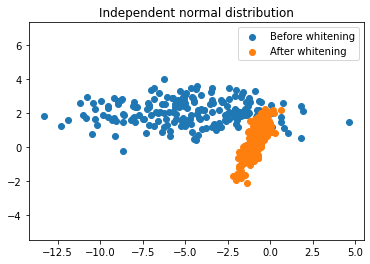

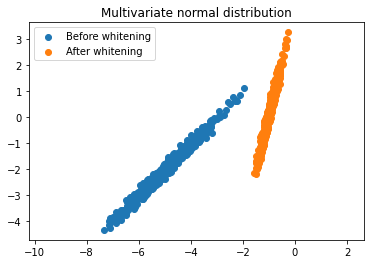

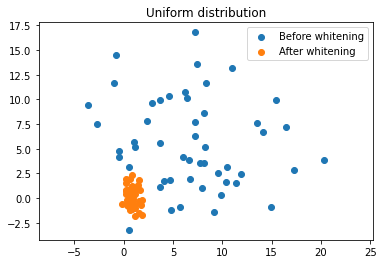

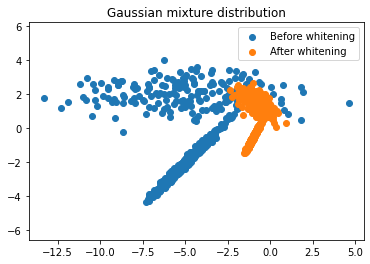

In [10]:
X_diag_normal = np.random.multivariate_normal([-5, 2.], [[10, 0], [0, 0.5]], size=200)
X_multivariate_normal = np.random.multivariate_normal([-5, -2], [[1, 0.99], [0.99, 1]], size=500)
X_uniform = np.random.normal(6, 5, size=(50, 2))
X_gmm = np.concatenate((X_multivariate_normal, X_diag_normal), axis=0)
    
utils.scatter_with_whiten(X_diag_normal, whiten, name="Independent normal distribution")
utils.scatter_with_whiten(X_multivariate_normal, whiten, name="Multivariate normal distribution")
utils.scatter_with_whiten(X_uniform, whiten, name="Uniform distribution")
utils.scatter_with_whiten(X_gmm, whiten, name="Gaussian mixture distribution")

## Standaryzacja a whitening
W pierwszym notebooku implementowaliśmy następującą funkcję, która wykonuje zadanie podobne do whiteningu:

$$ f(x_{ij}) = \frac{x_{ij} - \mu_j}{\sigma_j} $$

Tę funkcję nazwijmy **standaryzacją**. Czym zatem różni się standaryzacja od whiteningu? Czy nie wystarczy znormalizować kolumn i zamiast tego musimy wykonywać znacznie bardziej kosztowną operację liczenia i odwracania macierzy kowariancji?

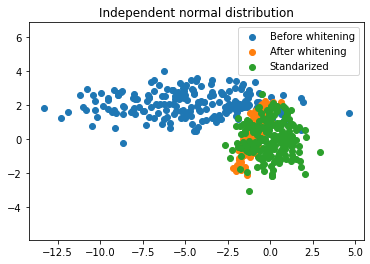

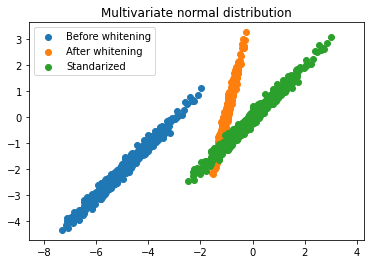

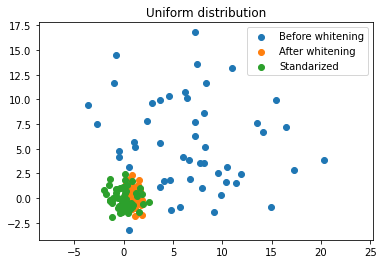

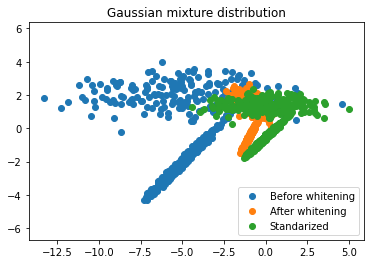

In [11]:
utils.scatter_with_whiten(X_diag_normal, whiten, name="Independent normal distribution", standarize=True)
utils.scatter_with_whiten(X_multivariate_normal, whiten, name="Multivariate normal distribution", standarize=True)
utils.scatter_with_whiten(X_uniform, whiten, name="Uniform distribution", standarize=True)
utils.scatter_with_whiten(X_gmm, whiten, name="Gaussian mixture distribution", standarize=True)

# Zadanie 3
Należy:
1. Wysamplować $10000$ przykładów z rozkładu normalnego $\mathcal{N}(\mu, \sigma)$. **Należy wybrać niestandardowe parametry**, tzn. $\mu \neq 0$ oraz $\sigma \neq 1$.
2. Następnie należy policzyć, jaki procent wylosowanych przykładów, znajduje się od środka w odległości większej niż: 
    * $1\sigma$ (tzn. $|x - \mu| > 1\sigma$)
    * $2\sigma$ (tzn. $|x - \mu| > 2\sigma$)
    * $3\sigma$ (tzn. $|x - \mu| > 3\sigma$)
    
3. Wypisać wszystkie przykłady, które wpadają do ostatniej kategorii (tzn. są oddalone o co najmniej $3\sigma$ od średniej).

In [15]:
# Podpunkt 1: Wysamplować 10000 przykładów z rozkładu normalnego
loc = 6 # średnia wybranego rozkładu normalnego
scale = 5 # odchylenie standardowe wybranego rozkładu normalnego
X = np.random.normal(loc=loc,scale=scale,size=(1,10000))
# Podpunkt 2: Wyliczyć i wypisać procent 

sigmas = [1,2,3]
sigma_values = []
for i in sigmas:
    sigma_mean = np.abs(X - np.mean(X))
    sigma = np.where(sigma_mean > i * scale)
    sigma_values.append([sigma_mean[sigma]])

######
    
sig_1 = sigma_values[0]
sig_2 = sigma_values[1]
sig_3 = sigma_values[2]

######

all = X.shape[1]
sigma_1_percent = (len(sig_1[0])/all) * 100
sigma_2_percent = (len(sig_2[0])/all) * 100
sigma_3_percent = (len(sig_3[0])/all) * 100
print(
    sigma_1_percent,
    sigma_2_percent,
    sigma_3_percent)

# Podpunkt 3: Wypisać elementy, które są oddalone od średniej o 3 sigma.

# Trochę wizualizacji
# utils.visualize_normal_dist(X, loc, scale)

32.029999999999994 4.6 0.25
